In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

In [3]:
import pandas as pd
from src import ComputationalHypergraphDiscovery as CHD
#from ComputationalHypergraphDiscovery.Modes import LinearMode, QuadraticMode, GaussianMode
import numpy as onp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from tqdm import tqdm
import jax.numpy as np
import glob


In [4]:
additional=10

df=pd.read_csv('./BCR_uniform.csv')
df=df[df.columns[df.std(axis=0)!=0]]
relabel={n:n.replace('\\','/') for n in df.columns}
df.columns=[n.replace('\\','/') for n in df.columns]
cut=2400
df_train=df[:cut]
df_test=df[cut:]
df

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,$/partial_t S1112$,$/partial_t S1113$,$/partial_t S1114$,$/partial_t S1115$,$/partial_t S1116$,$/partial_t S1117$,$/partial_t S1118$,$/partial_t S1119$,$/partial_t S1120$,$/partial_t S1121$
0,0.872995,0.258391,0.222548,0.865075,0.006389,0.307317,0.689190,0.612599,0.032746,0.004956,...,414.121025,-607.379209,245.860647,1236.455751,3885.052506,1432.921968,2435.456029,1837.290757,664.621838,381.660465
1,0.177448,0.448519,0.892770,0.192859,0.771864,0.928737,0.017848,0.289916,0.000958,0.010268,...,355.803877,-858.675959,-2.037466,862.236998,2967.906927,2170.672995,2175.999670,2588.511472,1692.116035,1287.014376
2,0.340680,0.570078,0.998653,0.057214,0.491247,0.267313,0.412853,0.227748,0.658479,0.979586,...,212.052065,-430.789093,1091.800894,154.178383,3163.325683,1090.303392,1026.580469,1928.537903,2622.456177,550.399502
3,0.479903,0.526346,0.105414,0.382804,0.303066,0.459272,0.186838,0.460450,0.082807,0.546456,...,200.863198,-1554.053313,-890.349184,1708.265119,2454.615943,879.167918,2348.641473,1899.636315,2353.714969,1602.994661
4,0.779705,0.506842,0.873881,0.579235,0.133748,0.064157,0.164629,0.422048,0.720382,0.984089,...,-22.323701,-1081.489019,-1452.138727,1409.851417,2868.674541,1911.408665,3239.058777,2566.731976,981.383939,2672.800697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.741938,0.553394,0.122552,0.315124,0.605178,0.413084,0.535587,0.350225,0.756366,0.215708,...,244.472082,-529.148679,326.892413,879.321891,3084.463411,639.180626,1457.690128,2561.662390,1399.592603,738.031081
9996,0.976695,0.322520,0.061247,0.264253,0.976927,0.330817,0.650543,0.672399,0.353327,0.824186,...,60.713642,777.954782,-725.398390,1524.756426,1713.113517,1064.130513,1874.589536,2540.887684,-742.985098,1629.053069
9997,0.505065,0.177356,0.817247,0.856556,0.157023,0.521938,0.536912,0.888402,0.685757,0.966430,...,-73.246748,-426.498893,-241.613761,1596.848887,2476.240785,1243.812527,3107.594789,1865.723347,1313.990506,2303.902759
9998,0.156244,0.458165,0.306584,0.610349,0.179289,0.630377,0.554515,0.446829,0.517074,0.125642,...,-283.209440,-900.256308,96.279575,692.457902,2597.738457,1111.256518,2492.391004,2029.298082,52.398710,931.602062


In [5]:
graph_discovery=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)

making a function that is non-interpolatory


In [6]:
graphs = [pickle.load(open(path, "rb")) for path in tqdm(glob.glob('./results_all_uniform_BCR_1200/*.pkl'))]
graphs = [nx.relabel_nodes(graph, relabel) for graph in graphs]
for g in graphs:
    graph_discovery.G=nx.compose(graph_discovery.G,g)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


In [7]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
true_graph=nx.relabel_nodes(true_graph, relabel)

In [8]:
#compute the true positives and false negatives. For each edge in graph_discovery.G, if it is in true_graph, it is a true positive, otherwise it is a false positive
#true_graph is a networkx graph, graph_discovery.G is a networkx graph
true_positives={}
false_positives={}
false_negatives={}
true_negatives={}
random_true_positives={}
random_false_positives={}
random_false_negatives={}
random_true_negatives={}
ancestor_numbers={}
for node in graph_discovery.G.nodes:
    if 'partial' not in node:
        continue
    true_positives[node]=0
    false_positives[node]=0
    false_negatives[node]=0
    true_negatives[node]=0
    true_ancestor_number=len(nx.ancestors(true_graph,node))
    ancestor_number=len(nx.ancestors(graph_discovery.G,node))
    ancestor_numbers[node]=ancestor_number
    random_true_positives[node]=true_ancestor_number*ancestor_number/1122
    random_false_positives[node]=(1122-true_ancestor_number)*ancestor_number/1122
    random_false_negatives[node]=true_ancestor_number*(1122-ancestor_number)/1122
    random_true_negatives[node]=(1122-true_ancestor_number)*(1122-ancestor_number)/1122

    for ancestor in graph_discovery.G.nodes:
        if 'partial' in ancestor:
            continue
        predicted=graph_discovery.G.has_edge(ancestor,node)
        true=true_graph.has_edge(ancestor,node)
        
        if predicted and true:
            true_positives[node]+=1
        elif predicted and not true:
            false_positives[node]+=1
        elif not predicted and true:
            false_negatives[node]+=1
        else:
            true_negatives[node]+=1


true_positive_rates={node:true_positives[node]/(true_positives[node]+false_negatives[node]) for node in true_positives}
false_positive_rates={node:false_positives[node]/(false_positives[node]+true_negatives[node]) for node in false_positives}
false_discovery_rates={node:false_positives[node]/(false_positives[node]+true_positives[node]) for node in false_positives}
true_negative_rates={node:true_negatives[node]/(true_negatives[node]+false_positives[node]) for node in true_negatives}
random_true_positive_rates={node:random_true_positives[node]/(random_true_positives[node]+random_false_negatives[node]) for node in random_true_positives}
random_false_positive_rates={node:random_false_positives[node]/(random_false_positives[node]+random_true_negatives[node]) for node in random_false_positives}
random_false_discovery_rates={node:random_false_positives[node]/(random_false_positives[node]+random_true_positives[node]) for node in random_false_positives}
random_true_negative_rates={node:random_true_negatives[node]/(random_true_negatives[node]+random_false_positives[node]) for node in random_true_negatives}


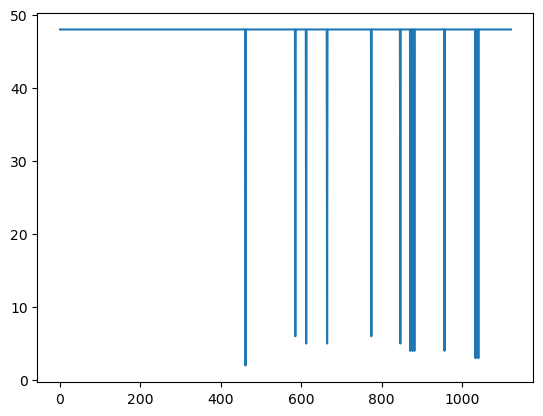

In [9]:
plt.plot(ancestor_numbers.values())

(array([1.00e+00, 0.00e+00, 2.00e+00, 0.00e+00, 4.00e+00, 0.00e+00,
        3.00e+00, 0.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

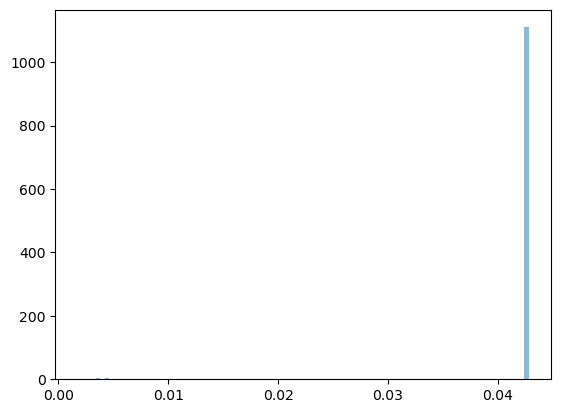

In [12]:

plt.hist(data_random,bins=100,density=False,alpha=0.5,label='expected at random')

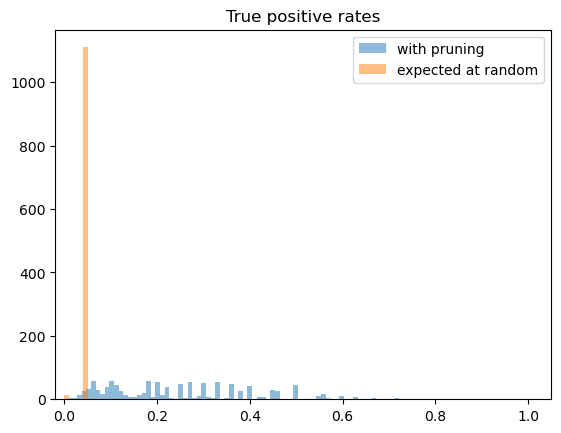

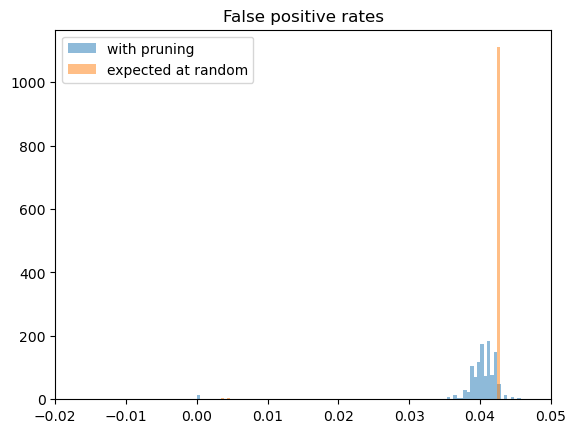

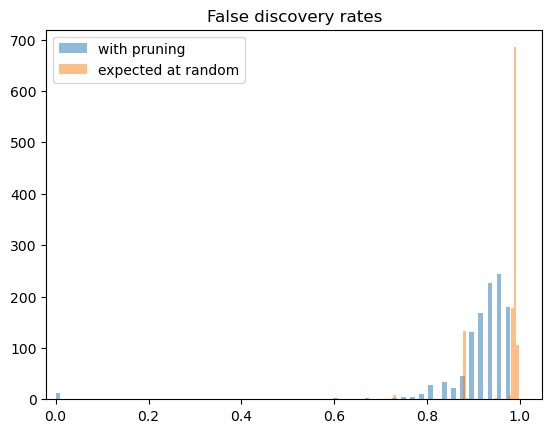

In [16]:
plt.figure()
data=list(true_positive_rates.values())
data_random=list(random_true_positive_rates.values())
plt.hist(data,bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(data_random,bins=100,density=False,alpha=0.5,label='expected at random',range=(0,1))
plt.title('True positive rates')
plt.xlim(left=-0.02)
plt.legend()
plt.figure()
plt.hist(list(false_positive_rates.values()),bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(list(random_false_positive_rates.values()),bins=100,density=False,alpha=0.5,label='expected at random')
plt.title('False positive rates')
plt.legend()
plt.xlim(left=-0.02)
plt.figure()
plt.hist(list(false_discovery_rates.values()),bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(list(random_false_discovery_rates.values()),bins=100,density=False,alpha=0.5,label='expected at random')
plt.title('False discovery rates')
plt.legend()
plt.xlim(left=-0.02)
plt.show()